In [10]:
# %load_ext autoreload
# %autoreload 2
from jax import config

config.update("jax_enable_x64", True)
import sys
from dataclasses import dataclass

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

import matplotlib as mpl

mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["savefig.format"] = "pdf"
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["figure.autolayout"] = True
import pandas as pd
import tensorflow_probability as tfp
from jax import grad, hessian, jit, vmap
from jaxtyping import Array, Float, install_import_hook
from matplotlib import rcParams
from tqdm.notebook import tqdm
import scipy.io as sio
import numpy as np

sys.path.append("src")
from kernels.DiagonalKernel3D import DiagonalKernel3D
from kernels.CurlFreeKernel import CurlFreeKernel
from kernels.ArtificialKernel3D import ArtificialKernel3D
from kernels.ArtificialKernelExplicit3D import ArtificialKernelExplicit3D
from utils.data_tools import generate_data, transform_data, regular_train_points, add_collocation_points
from utils.performance import rmse
from utils.plotting_tools import plot_data, plot_pred

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

# Enable Float64 for more stable matrix inversions.
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
colors = rcParams["axes.prop_cycle"].by_key()["color"]

## Dataset

In [11]:
mat = sio.loadmat('data/dataSet14.mat')
t = mat["data_obj"][0,1].item()[0][:-1]
pos = mat["data_obj"][0,1].item()[1][:-1]
mag = mat["data_obj"][0,1].item()[2][:-1]
quat = mat["data_obj"][0,1].item()[3][:-1]

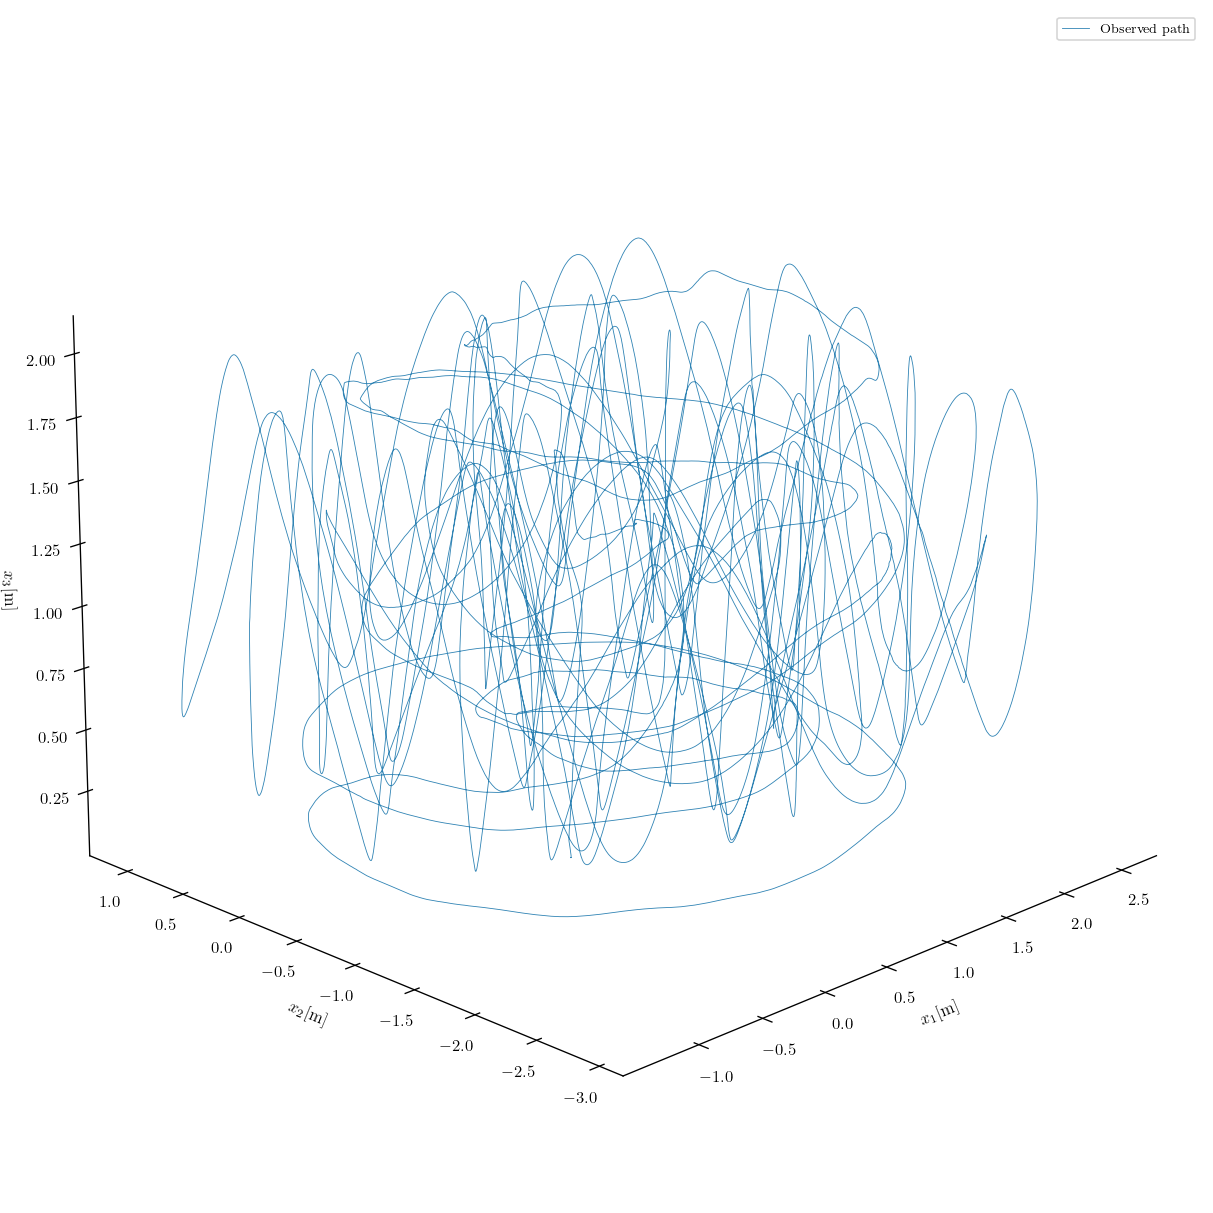

In [30]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
x,y,z = pos[:,0], pos[:,1], pos[:,2]
ax.plot(x, y, z, label='Observed path', linewidth=0.5)
ax.view_init(elev=20, azim=225)
ax.set_xlabel('$x_1$[m]')
ax.set_ylabel('$x_2$[m]')
ax.set_zlabel('$x_3$[m]')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.grid(False)
ax.legend()
plt.savefig('figures/observed_path_3D.pdf', dpi=300, format='pdf')
plt.show()

In [33]:
magnitude = np.linalg.norm(mag, axis=1)

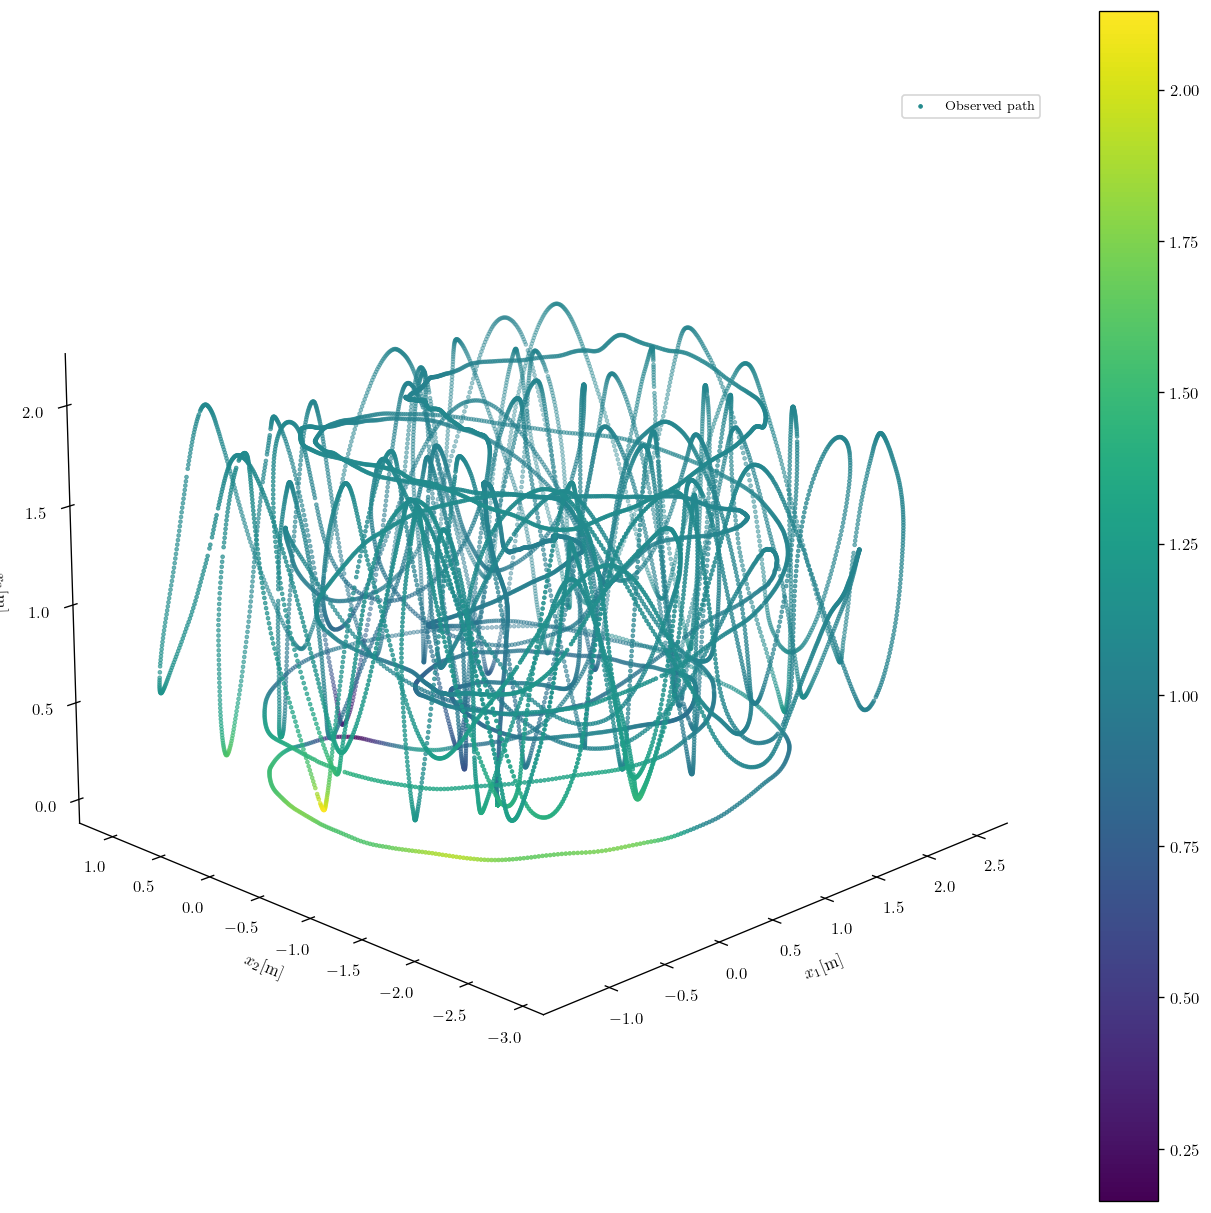

In [46]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
x,y,z = pos[:,0], pos[:,1], pos[:,2]
p = ax.scatter(x, y, z, label='Observed path', linewidth=0.5, c=magnitude, cmap='viridis', marker='.')
plt.colorbar(p)
ax.view_init(elev=20, azim=225)
ax.set_xlabel('$x_1$[m]')
ax.set_ylabel('$x_2$[m]')
ax.set_zlabel('$x_3$[m]')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.grid(False)
ax.legend()
plt.savefig('figures/observed_path_3D_colours.pdf', dpi=300, format='pdf')
plt.show()

### Split into training and test

In [22]:
posmag = jnp.hstack([pos, mag])
master_key = jr.key(0)
sample_pos = jr.choice(master_key, posmag, (1500,), replace=False)
train_posmag = sample_pos[:500]
test_posmag = sample_pos[500:]
train_pos = train_posmag[:, :3]
train_mag = train_posmag[:, 3:]
test_pos = test_posmag[:, :3]
test_mag = test_posmag[:, 3:]

In [23]:
## Evenly spaced points
total_points = posmag.shape[0]
indices = jnp.linspace(0, total_points - 1, 1500, dtype=jnp.int32)
train_indices = indices[::3]
test_indices = jnp.setdiff1d(indices, train_indices)
train_pos = posmag[train_indices, :3]
train_mag = posmag[train_indices, 3:]
test_pos = posmag[test_indices, :3]
test_mag = posmag[test_indices, 3:]

In [24]:
# Real points
dataset_train, dataset_test = transform_data(train_pos,train_mag,test_pos,test_mag)
dataset_coll_train_75 = add_collocation_points(dataset_train, test_pos, 75, master_key, 3)
dataset_coll_train_1000 = add_collocation_points(dataset_train, test_pos, 1000, master_key, 3)

# Testing the kernel

The first cell compares elements of the kernel to the analytic expressions of the various derivatives.
The second cell computes the full K matrix for train points (make sure there are only two train points!)

In [25]:
DiagonalKernel3D().cross_covariance(dataset_train.X,dataset_train.X)

Array([[1.        , 0.91050051, 0.49700036, ..., 0.        , 0.        ,
        0.        ],
       [0.91050051, 1.        , 0.75298094, ..., 0.        , 0.        ,
        0.        ],
       [0.49700036, 0.75298094, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.99999998,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.99999998, 1.        ,
        0.99999999],
       [0.        , 0.        , 0.        , ..., 1.        , 0.99999999,
        1.        ]], dtype=float64)

In [26]:
ArtificialKernel3D().cross_covariance(dataset_train.X,dataset_train.X)

Array([[1.        , 0.91050051, 0.49700036, ..., 0.        , 0.        ,
        0.        ],
       [0.91050051, 1.        , 0.75298094, ..., 0.        , 0.        ,
        0.        ],
       [0.49700036, 0.75298094, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.99999998,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.99999998, 1.        ,
        0.99999999],
       [0.        , 0.        , 0.        , ..., 1.        , 0.99999999,
        1.        ]], dtype=float64)

In [27]:
ArtificialKernelExplicit3D().cross_covariance(dataset_train.X,dataset_train.X)

Array([[1.        , 0.91050051, 0.49700036, ..., 0.        , 0.        ,
        0.        ],
       [0.91050051, 1.        , 0.75298094, ..., 0.        , 0.        ,
        0.        ],
       [0.49700036, 0.75298094, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.99999998,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.99999998, 1.        ,
        0.99999999],
       [0.        , 0.        , 0.        , ..., 1.        , 0.99999999,
        1.        ]], dtype=float64)

In [28]:
def initialise_gp(kernel, mean, dataset):
    prior = gpx.gps.Prior(mean_function=mean, kernel=kernel)
    likelihood = gpx.likelihoods.Gaussian(
        num_datapoints=dataset.n, obs_stddev=jnp.array([1e-6], dtype=jnp.float64) #TODO check what sigma_n should be
    )
    posterior = prior * likelihood
    return posterior

def optimise_mll(posterior, dataset, NIters=1000, verbose=True):
    # define the MLL using dataset_train
    objective = gpx.objectives.ConjugateMLL(negative=True)
    # Optimise to minimise the MLL
    opt_posterior, history = gpx.fit_scipy(
        model=posterior,
        objective=objective,
        train_data=dataset,
        max_iters=NIters,
        verbose = verbose
    )
    if verbose:
        print("Length of history:",len(history))
    # print(history)
    return opt_posterior

In [29]:
from jax.tree_util import tree_structure
from jax.flatten_util import ravel_pytree

from gpjax.distributions import GaussianDistribution


def get_posterior(kernel,dataset_train, verbose = False, params = False):
    """Predicts the latent function at the test points given the training data and the kernel.

    Args:
        kernel (gpx kernel): Kernel
        dataset_train (jnp.ndarray): Training data
        test_X (jnp.ndarray): Test inputs

    Returns:
        jnp.ndarray: Output of the latent function at the test points
    """
    meanf = gpx.mean_functions.Zero()
    posterior = initialise_gp(kernel, meanf, dataset_train)
    opt_posterior = optimise_mll(posterior, dataset_train, verbose = verbose)

    if verbose:
        _params = ravel_pytree(posterior)[0].tolist()
        _params[2] = _params[2]**0.5 
        objective = gpx.objectives.ConjugateMLL(negative=True)
        print("Initial: σ_n, l, σ_f:", _params)
        print("Initial MLL:", objective(posterior, dataset_train))
        _params = ravel_pytree(opt_posterior)[0].tolist()
        _params[2] = _params[2]**0.5 
        print("Final: σ_n, l, σ_f:", _params)
        print("Final MLL:", objective(opt_posterior, dataset_train))
        
    if params:
        return opt_posterior, ravel_pytree(opt_posterior)[0]
    return opt_posterior

def latent_distribution(opt_posterior, pos_3d, dataset_train):
    latent = opt_posterior.predict(pos_3d, train_data=dataset_train)
    opt_posterior.predict(pos_3d, train_data=dataset_train).mean()
    latent_mean = latent.mean()
    return latent_mean

def predict(opt_posterior, test_X, dataset_train, output_dim = 2):
    pred_mean = latent_distribution(
        opt_posterior, test_X, dataset_train
    )
    function_pred = pred_mean[test_X[:,output_dim]!=output_dim].reshape(-1,output_dim,order="F")
    return function_pred


In [30]:
predictions = {}
opt_posterior_diag, diag_params = get_posterior(DiagonalKernel3D(), dataset_train, verbose = True, params=True)

Optimization terminated successfully.
         Current function value: -2059.713186
         Iterations: 49
         Function evaluations: 94
         Gradient evaluations: 94
Length of history: 50
Initial: σ_n, l, σ_f: [1e-06, 1.0, 1.0]
Initial MLL: 184647.61941618743
Final: σ_n, l, σ_f: [0.029018900050888117, 0.7185090691122284, 0.4601861615455714]
Final MLL: -2059.71318603428


In [31]:
type(diag_params)

jaxlib.xla_extension.ArrayImpl

In [32]:
print(diag_params)

[0.0290189  0.71850907 0.2117713 ]


In [33]:
diag_params

Array([0.0290189 , 0.71850907, 0.2117713 ], dtype=float64)

In [14]:
mean_diag = predict(opt_posterior_diag,dataset_test.X,dataset_train,3)
predictions.update({"Diagonal Kernel":mean_diag})

In [15]:
opt_posterior_curlfree = get_posterior(CurlFreeKernel(), dataset_train, verbose = True)

Optimization terminated successfully.
         Current function value: -2237.096407
         Iterations: 44
         Function evaluations: 106
         Gradient evaluations: 105
Length of history: 45
Initial: σ_n, l, σ_f: [1e-06, 1.0, 1.0]
Initial MLL: 333545.080250894
Final: σ_n, l, σ_f: [0.026371794352396442, 0.7314852544288614, 0.6474304195938362]
Final MLL: -2237.0964071632534


In [17]:
mean_curlfree = predict(opt_posterior_curlfree,dataset_test.X,dataset_train,3)
predictions.update({"CurlFree Kernel":mean_curlfree})

In [12]:
def steal_diag_params(diag_params, dataset_coll_train):
    meanf = gpx.mean_functions.Zero()
    art_posterior = initialise_gp(ArtificialKernelExplicit3D(), meanf, dataset_coll_train)
    ravel_func = ravel_pytree(art_posterior)[1]
    opt_art_posterior = ravel_func(diag_params)
    return opt_art_posterior

In [13]:
opt_posterior_art = steal_diag_params(diag_params, dataset_coll_train_1000)

In [ ]:
mean_artificial = predict(opt_posterior_art,dataset_test.X,dataset_coll_train_1000,3)
predictions.update({"Artificial Kernel":mean_artificial})

In [ ]:
mean_artificial_2 = vmap(lambda x: opt_posterior_art.predict(x, dataset_coll_train_1000).mean(),0)(dataset_test.X[:,None])

In [ ]:
dataset_coll_train_1000

(1500, 1500)

(4,) (4,)
1
None


Array([[1.        , 0.91050051, 0.49700036, ..., 0.        , 0.        ,
        0.        ],
       [0.91050051, 1.        , 0.75298094, ..., 0.        , 0.        ,
        0.        ],
       [0.49700036, 0.75298094, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.99999998,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.99999998, 1.        ,
        0.99999999],
       [0.        , 0.        , 0.        , ..., 1.        , 0.99999999,
        1.        ]], dtype=float64)

500 train points
1000 test points
1000 collocation point

4500

In [17]:
rmse(mean_artificial_2, dataset_test.y)

Array(0.03306817, dtype=float64)

In [74]:
rmse(mean_artificial_2, dataset_test.y)

Array(0.03158196, dtype=float64)

In [30]:
rmse(mean_diag, dataset_test.y), rmse(mean_curlfree, dataset_test.y), rmse(mean_artificial, dataset_test.y), rmse(mean_artificial_2, dataset_test.y)

(Array(0.03169761, dtype=float64),
 Array(0.02781767, dtype=float64),
 Array(0.03141201, dtype=float64),
 Array(0.03135691, dtype=float64))

In [ ]:
0.04159168328479807 0.03332769129054468 0.04197473814888296

In [ ]:
0.04159168328479807 0.03332769129054468 0.04197473814888296

In [ ]:
150, old inverse: 0.085707718934845 0.07181807348007782 0.08438421941276515
150, new inverse: 0.08570771893484408 0.07181807348007548 0.08439652101258563
200, old inverse: 0.08612303503947862 0.08069966929040474 0.083396575763773
200, new inverse: 0.0861230350394793 0.080699669290409 0.0833689400069559
250, old inverse: 0.07195161149818306 0.07103614244547928 0.06541152209249662 [138]
250, new inverse: 0.07195161149818283 0.07103614244549084 0.06538926422262516
500, old inverse: 0.041671611898135355 0.033911616411045925 0.04204654567657105
500, new inverse: 0.04159168328479807 0.03332769129054468 0.04197473814888296

In [ ]:
rmse(jnp.zeros(dataset_test.y.shape), dataset_test.y)

Array(0.6229608, dtype=float64)

In [34]:
import numpy as np

N_c_list = [25, 50, 75, 100, 150, 200, 300, 400]

nrRepeat = 50
errDiag_all=np.zeros((nrRepeat,1))
errCust_all=np.zeros((nrRepeat,1))
errDiagObs_all=np.zeros((nrRepeat,len(N_c_list)))
L_opt_diag_all = np.zeros((nrRepeat,1))
L_opt_cust_all = np.zeros((nrRepeat,1))
L_opt_diagObs_all = np.zeros((nrRepeat,len(N_c_list)))

noise = 1e-4
if nrRepeat == 1:
    verbose = True
else:
    verbose = False

train_artificial_posterior = True

    

for i in tqdm(range(nrRepeat), desc = f"Repeating experiment {nrRepeat} times"):
    ## Set seed
    master_key = jr.key(i)

    ## Get data
    x,y,xtest,ytest = generate_data(master_key,a,n,N_test_1D,noise)
    ## Turn on if you want to use regular training points
    # x,y = regular_train_points(master_key, a=a, n=n, noise=noise)
    dataset_train, dataset_test = transform_data(x,y,xtest,ytest,master_key)
    
    ## Diagonal Kernel
    opt_posterior_diag, diag_params = get_posterior(DiagonalKernel(),dataset_train, verbose = verbose, params=True) 
    objective = gpx.objectives.ConjugateMLL(negative=True)
    MLL = objective(opt_posterior_diag, dataset_train)
    L_opt_diag_all[i] = MLL.item()
    ypred = predict(opt_posterior_diag,dataset_test.X,dataset_train)
    errDiag_all[i] = rmse(ytest,ypred).item()

    ## Divergence-free Kernel
    opt_posterior_cust = get_posterior(DivFreeKernel(),dataset_train, verbose = verbose)
    objective = gpx.objectives.ConjugateMLL(negative=True)
    MLL = objective(opt_posterior_cust, dataset_train)
    L_opt_cust_all[i] = MLL.item()
    ypred = predict(opt_posterior_cust,dataset_test.X,dataset_train)
    errCust_all[i] = rmse(ytest,ypred).item()
    
    ## Artificial Kernel
    for j,N_c in tqdm(enumerate(N_c_list), desc = f"ArtifKernel with {len(N_c_list)} different N_c values", leave = True, total = len(N_c_list)):
        dataset_coll_train = add_collocation_points(dataset_train, xtest, N_c, master_key)
        if train_artificial_posterior:
            opt_posterior = get_posterior(ArtificialKernel(),dataset_coll_train, verbose = verbose)
        else:
            opt_posterior_art = steal_diag_params(diag_params, dataset_coll_train)
        objective = gpx.objectives.ConjugateMLL(negative=True)
        MLL = objective(opt_posterior_art, dataset_coll_train)
        L_opt_diagObs_all[i,j] = MLL.item()
        ypred = predict(opt_posterior_art,dataset_test.X,dataset_coll_train)
        errDiagObs_all[i,j] = rmse(ytest,ypred).item()
    

Repeating experiment 50 times:   0%|          | 0/50 [00:00<?, ?it/s]

ArtifKernel with 8 different N_c values:   0%|          | 0/8 [00:00<?, ?it/s]

ArtifKernel with 8 different N_c values:   0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [19]:
import numpy as np

if train_artificial_posterior:
    directory = "results/Trained Artificial Posterior"
else:
    directory = "results/Stolen Artificial Posterior"

# Define a dictionary to store the arrays
arrays = {
    'L_opt_cust_all': L_opt_cust_all,
    'L_opt_diagObs_all': L_opt_diagObs_all,
    'L_opt_diag_all': L_opt_diag_all,
    'errCust_all': errCust_all,
    'errDiagObs_all': errDiagObs_all,
    'errDiag_all': errDiag_all
}

## Save the arrays
# for name, array in arrays.items():
#     np.save(f'{name}.npy', array)



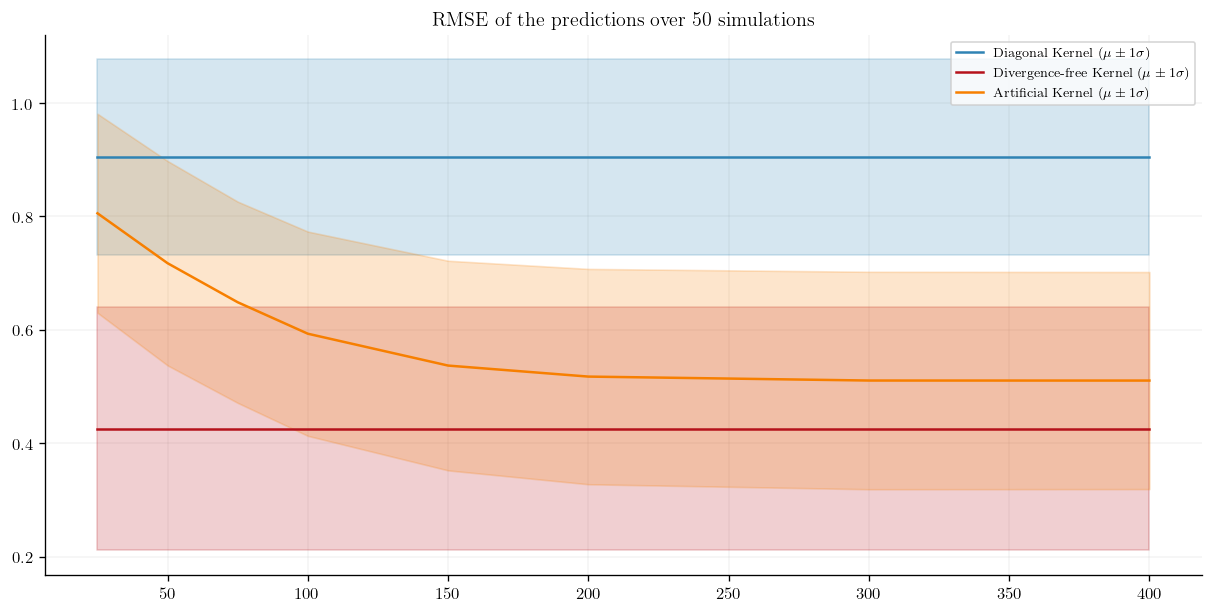

In [37]:
directory = "data/Stolen Artificial Posterior"

def plot_results(directory):
    L_opt_cust_all = np.load(join(directory,'L_opt_cust_all.npy'))
    L_opt_diagObs_all = np.load(join(directory,'L_opt_cust_all.npy'))
    L_opt_diag_all = np.load(join(directory,'L_opt_diag_all.npy'))
    errCust_all = np.load(join(directory,'errCust_all.npy'))
    errDiagObs_all = np.load(join(directory,'errDiagObs_all.npy'))
    errDiag_all = np.load(join(directory,'errDiag_all.npy'))

    # Plot the results
    plt.figure(figsize=(10,5))

    errDiag = errDiag_all.mean()
    errDiagStd = errDiag_all.std()

    errCust = errCust_all.mean()
    errCustStd = errCust_all.std()

    errDiagObs = errDiagObs_all.mean(axis=0)
    errDiagObsStd = errDiagObs_all.std(axis=0)

    errDiag_plot = jnp.array([errDiag] * len(N_c_list))
    errCust_plot = jnp.array([errCust] * len(N_c_list))

    plt.plot(N_c_list, errDiag_plot, label = 'Diagonal Kernel ($\mu \pm 1\sigma$)', color = colors[0])
    plt.fill_between(N_c_list, errDiag_plot - errDiagStd, errDiag_plot + errDiagStd, alpha = 0.2, color = colors[0])

    plt.plot(N_c_list, errCust_plot, label = 'Divergence-free Kernel ($\mu \pm 1\sigma$)', color = colors[1])
    plt.fill_between(N_c_list, errCust_plot - errCustStd, errCust_plot + errCustStd, alpha = 0.2, color = colors[1])

    plt.plot(N_c_list, errDiagObs, label = 'Artificial Kernel ($\mu \pm 1\sigma$)', color = colors[2])
    plt.fill_between(N_c_list, errDiagObs - errDiagObsStd, errDiagObs + errDiagObsStd, alpha = 0.2, color = colors[2])

    plt.legend()

plot_results(directory)
plt.title('RMSE of the predictions over 50 simulations')
plt.savefig('figures/Stolen Artificial Posterior.png', dpi=300)

In [ ]:
import numpy as np
nrRepeat = 50
N_c_list = [25, 50, 75, 100, 150, 200, 300, 400]
errDiagObs_all=np.zeros((nrRepeat,len(N_c_list)))
errCust_all=np.zeros((nrRepeat,1))
errDiag_all=np.zeros((nrRepeat,1))

for i in tqdm(range(nrRepeat)):
    master_key = jr.key(i)
    x,y,xtest,ytest = generate_data(master_key,a,n,N_test_1D,noise)
    dataset_train, dataset_test = transform_data(x,y,xtest,ytest,master_key,p=0)
    ypred = predict(DiagonalKernel(),dataset_train,dataset_test.X)
    errDiag_all[i] = rmse(ytest,ypred).item()
    ypred = predict(DivFreeKernel(),dataset_train,dataset_test.X)
    errCust_all[i] = rmse(ytest,ypred).item()
    for j,N_c in enumerate(N_c_list):
        dataset_coll_train, dataset_test = transform_data(x,y,xtest,ytest,master_key,N_c/N_P)
        ypred = predict(ArtificialKernel(),dataset_coll_train,dataset_test.X)
        errDiagObs_all[i,j] = rmse(ytest,ypred).item()

np.save('errCust_all.npy', errCust_all)
np.save('errDiag_all.npy', errDiag_all)
np.save('errDiagObs_all.npy', errDiagObs_all)

100%|██████████| 50/50 [1:08:18<00:00, 81.98s/it] 


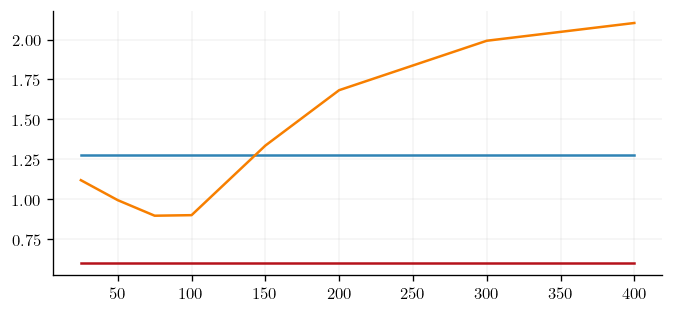

In [ ]:
plt.plot(N_c_list, [errDiag_all.mean()]*len(N_c_list),label="Diagonal Kernel")
plt.plot(N_c_list, [errCust_all.mean()]*len(N_c_list),label="Divergence-free Kernel")
plt.plot(N_c_list, errDiagObs_all.mean(axis=0))

Visually, the Helmholtz model performs better than the velocity model, preserving the local structure of the $\mathbf{F}$. Since we placed priors on $\Phi$ and $\Psi$, the construction of $\mathbf{F}$ allows for correlations between the dimensions (non-zero off-diagonal elements in the Gram matrix populated by $k_\text{Helm}\left(\mathbf{X},\mathbf{X}^{\prime}\right)$ ).

## Negative log predictive densities
Lastly, we directly compare the velocity and Helmholtz models by computing the [negative log predictive densities](https://en.wikipedia.org/wiki/Negative_log_predictive_density) for each model. This is a quantitative metric that measures the probability of the ground truth given the data.

$$
\mathrm{NLPD}=-\sum_{i=1}^{2N} \log \left(  p\left(\mathcal{Y}_i = Y_{0,i} \mid \mathbf{X}_{i}\right) \right),
$$

where each $p\left(\mathcal{Y}_i \mid \mathbf{X}_i \right)$ is the marginal Gaussian distribution over $\mathcal{Y}_i$ at each test location, and $Y_{i,0}$ is the $i$-th component of the (massaged) test data that we reserved at the beginning of the notebook in $D_0$. A smaller value is better, since the deviation of the ground truth and the model are small in this case.

In [ ]:
%load_ext line_profiler
%lprun -f optimise_mll optimise_mll(posterior, dataset_train)

In [20]:

import numpy as np

N_c_list = [25, 50, 75, 100, 150, 200, 300, 400]

nrRepeat = 5
errDiag_all=np.zeros((nrRepeat,1))
errCust_all=np.zeros((nrRepeat,1))
errDiagObs_all=np.zeros((nrRepeat,len(N_c_list)))
L_opt_diag_all = np.zeros((nrRepeat,1))
L_opt_cust_all = np.zeros((nrRepeat,1))
L_opt_diagObs_all = np.zeros((nrRepeat,len(N_c_list)))

noise = 1e-4
if nrRepeat == 1:
    verbose = True
else:
    verbose = False

def lp_func(N_c_list, nrRepeat, errDiag_all, errCust_all, errDiagObs_all, L_opt_diag_all, L_opt_cust_all, L_opt_diagObs_all, noise, verbose):
    for i in tqdm(range(nrRepeat), desc = f"Repeating experiment {nrRepeat} times"):
    ## Set seed
        master_key = jr.key(i)

    ## Get data
        x,y,xtest,ytest = generate_data(master_key,a,n,N_test_1D,noise)
    ## Turn on if you want to use regular training points
    # x,y = regular_train_points(master_key, a=a, n=n, noise=noise)
        dataset_train, dataset_test = transform_data(x,y,xtest,ytest,master_key)
    
    ## Diagonal Kernel
        opt_posterior_diag, diag_params = get_posterior(DiagonalKernel(),dataset_train, verbose = verbose, params=True) 
        objective = gpx.objectives.ConjugateMLL(negative=True)
        MLL = objective(opt_posterior_diag, dataset_train)
        L_opt_diag_all[i] = MLL.item()
        ypred = predict(opt_posterior_diag,dataset_test.X,dataset_train)
        errDiag_all[i] = rmse(ytest,ypred).item()

    ## Divergence-free Kernel
        opt_posterior_cust = get_posterior(DivFreeKernel(),dataset_train, verbose = verbose)
        objective = gpx.objectives.ConjugateMLL(negative=True)
        MLL = objective(opt_posterior_cust, dataset_train)
        L_opt_cust_all[i] = MLL.item()
        ypred = predict(opt_posterior_cust,dataset_test.X,dataset_train)
        errCust_all[i] = rmse(ytest,ypred).item()
    
    ## Artificial Kernel
        for j,N_c in tqdm(enumerate(N_c_list), desc = f"ArtifKernel with {len(N_c_list)} different N_c values", leave = False, total = len(N_c_list)):
            dataset_coll_train = add_collocation_points(dataset_train, xtest, N_c, master_key)
            opt_posterior_art = steal_diag_params(diag_params, dataset_coll_train)

        ## If you want to train the artificial kernel
        # opt_posterior = get_posterior(ArtificialKernel(),dataset_coll_train, verbose = verbose)
            objective = gpx.objectives.ConjugateMLL(negative=True)
            MLL = objective(opt_posterior_art, dataset_coll_train)
            L_opt_diagObs_all[i,j] = MLL.item()
            ypred = predict(opt_posterior_art,dataset_test.X,dataset_coll_train)
            errDiagObs_all[i,j] = rmse(ytest,ypred).item()

In [21]:
%load_ext line_profiler
%lprun -f lp_func lp_func(N_c_list, nrRepeat, errDiag_all, errCust_all, errDiagObs_all, L_opt_diag_all, L_opt_cust_all, L_opt_diagObs_all, noise, verbose)

Repeating experiment 5 times:   0%|          | 0/5 [00:00<?, ?it/s]

ArtifKernel with 8 different N_c values:   0%|          | 0/8 [00:00<?, ?it/s]

ArtifKernel with 8 different N_c values:   0%|          | 0/8 [00:00<?, ?it/s]

ArtifKernel with 8 different N_c values:   0%|          | 0/8 [00:00<?, ?it/s]

ArtifKernel with 8 different N_c values:   0%|          | 0/8 [00:00<?, ?it/s]

ArtifKernel with 8 different N_c values:   0%|          | 0/8 [00:00<?, ?it/s]

Timer unit: 1e-07 s

Total time: 67.0325 s
File: C:\Users\neelm\AppData\Local\Temp\ipykernel_36196\1575634009.py
Function: lp_func at line 19

Line #      Hits         Time  Per Hit   % Time  Line Contents
    19                                           def lp_func(N_c_list, nrRepeat, errDiag_all, errCust_all, errDiagObs_all, L_opt_diag_all, L_opt_cust_all, L_opt_diagObs_all, noise, verbose):
    20         6     268007.0  44667.8      0.0      for i in tqdm(range(nrRepeat), desc = f"Repeating experiment {nrRepeat} times"):
    21                                               ## Set seed
    22         5      44722.0   8944.4      0.0          master_key = jr.key(i)
    23                                           
    24                                               ## Get data
    25         5     600981.0 120196.2      0.1          x,y,xtest,ytest = generate_data(master_key,a,n,N_test_1D,noise)
    26                                               ## Turn on if you want to use regul

In [ ]:

%load_ext line_profiler
%lprun -f lp_func lp_func(N_c_list, nrRepeat, errDiag_all, errCust_all, errDiagObs_all, L_opt_diag_all, L_opt_cust_all, L_opt_diagObs_all, noise, verbose)
opt_posterior_diag = get_posterior(DiagonalKernel3D(), dataset_train, verbose = True)
predictions.update({"Diagonal Kernel":predict(opt_posterior_diag,dataset_test.X,dataset_train,3)})

In [ ]:
# ensure testing data alternates between x0 and x1 components
def nlpd(mean, std, vel_test):
    vel_query = jnp.column_stack((vel_test[0], vel_test[1])).flatten()
    normal = tfp.substrates.jax.distributions.Normal(loc=mean, scale=std)
    return -jnp.sum(normal.log_prob(vel_query))


# compute nlpd for velocity and helmholtz
nlpd_vel = nlpd(velocity_mean, velocity_std, ytest)
nlpd_helm = nlpd(helmholtz_mean, helmholtz_std, ytest)

print("NLPD for Velocity: %.2f \nNLPD for Helmholtz: %.2f" % (nlpd_vel, nlpd_helm))

NameError: name 'velocity_mean' is not defined

In [ ]:

# diag = DiagonalKernel()
# print(diag(dataset_train.X[0], dataset_train.X[2]))
# print(diag(dataset_coll_train.X[0], dataset_coll_train.X[3]))

# rbf = gpx.kernels.RBF(active_dims=[0,1])
# print(rbf(dataset_train.X[0], dataset_train.X[2]))

z0=dataset_coll_train.X[1]
z1=dataset_coll_train.X[5]
v0=z0[:-1]
v1=z1[:-1]
print(z0,z1)

def k00(x,xp):
    expo = jnp.exp(-0.5 * jnp.sum((x-xp)**2))
    return expo

def k20(x,xp):
    expo = jnp.exp(-0.5 * jnp.sum((x-xp)**2))
    return -(x[0]-xp[0]) * expo

def k21(x,xp):
    expo = jnp.exp(-0.5 * jnp.sum((x-xp)**2))
    return -(x[1]-xp[1]) * expo

def k22(x,xp):
    expo = jnp.exp(-0.5 * jnp.sum((x-xp)**2))
    return (2 - (x[0]-xp[0])**2
              - (x[1]-xp[1])**2) * expo 

der = ArtificialKernel()
print(der(z0, z1))
print("----------------------")
print(k00(v0, v1))
print(k20(v0, v1))
print(k21(v0, v1))
print(k22(v0, v1))